In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split

In [2]:
data_path = 'datasets/archive/mitbih_train.csv'
data = pd.read_csv(data_path, header=None)
data = data.sample(100)
X = data[data.columns[:187]].values
Y = data[187].values

In [3]:
data_path = 'datasets/ECG5000/ECG5000_TRAIN.txt'
data = np.loadtxt(data_path)
#downsample = np.random.choice(np.arange(len(data)), size = 4500)

#X = data[downsample,1:]
#Y = data[downsample,0]
X = data[:,1:]
Y = data[:,0]

In [4]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15)
train_dset = TensorDataset(torch.Tensor(X_train).unsqueeze(2), torch.Tensor(Y_train))
val_dset = TensorDataset(torch.Tensor(X_val).unsqueeze(2), torch.Tensor(Y_val))

train_loader = DataLoader(train_dset, batch_size=64)
val_loader = DataLoader(val_dset, batch_size=64)

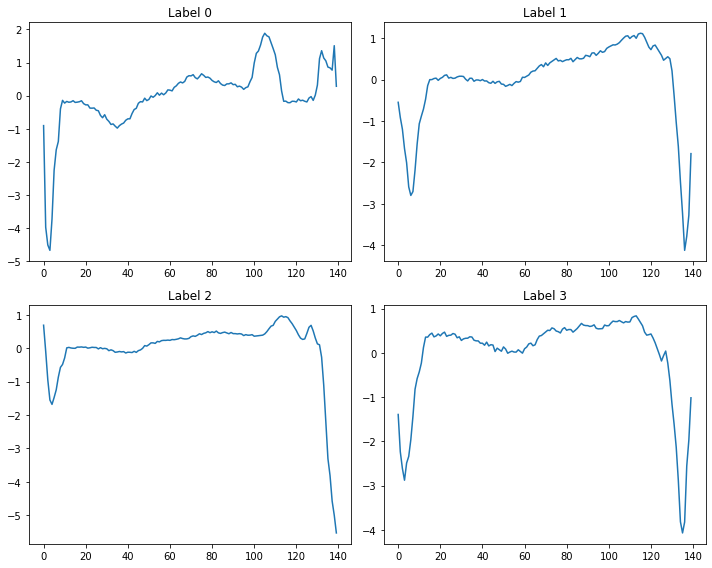

In [5]:
y_idx = [Y_train == i for i in np.unique(Y_train)]

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

for i, idx in enumerate(y_idx[:-1]):
    X_train_temp = X_train[idx]
    sig_idx = np.random.choice(np.arange(len(X_train_temp)))
    ax[i//2, i%2].plot(X_train_temp[sig_idx,:])
    ax[i//2, i%2].set_title(f'Label {i}')
plt.tight_layout()
plt.show()

In [6]:
import torch.distributions as dist
from torch.distributions import Distribution

class Normal_dist(Distribution):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.c = 2 * np.pi * torch.ones(1).to(self.device)
        self._dist = dist.normal.Normal(torch.zeros(1).to(self.device), torch.ones(1).to(self.device))
        self.name = 'gauss'

    def sample(self, mu, v):
        with torch.no_grad():
            eps = self._dist.sample(mu.size()).squeeze()
        scaled = eps.mul(v.sqrt())
        return scaled.add(mu)

    def log_pdf(self, inp, mu, v, reduce=True, param_shape=None):
        """compute the log-pdf of a normal distribution with diagonal covariance"""
        if param_shape is not None:
            mu, v = mu.view(param_shape), v.view(param_shape)
        lpdf = -0.5 * (torch.log(self.c) + v.log() + (inp - mu).pow(2).div(v))
        if reduce:
            if len(inp.shape) > 2:
                return lpdf.sum(dim=[1,2])
            else:
                return lpdf.sum(dim=-1)
        else:
            return lpdf

In [48]:
class LSTM_VAE(nn.Module):
    def __init__(self, input_shape, latent_size, hidden_size, output_len, device = "cpu") -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.input_shape = input_shape
        input_dim = input_shape[-1]
        self.device = device
        self.encoder = nn.LSTM(input_size = input_dim, hidden_size = hidden_size, batch_first = True)

        self.enc_to_latent = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=2*latent_size)
        )
        self.latent_to_dec = nn.Sequential(
            nn.Linear(in_features=latent_size, out_features=latent_size*output_len),
        )

        self.decoder = nn.LSTM(input_size = latent_size, hidden_size = hidden_size, batch_first = True)

        self.dec_to_out = nn.Linear(in_features = hidden_size, out_features=input_dim)

        self.prior_dist = Normal_dist()
        self.encoder_dist = Normal_dist()
        self.decoder_dist = Normal_dist()

        self.decoder_var = 0.1*torch.ones(1).to(device)
        self.prior_mean = torch.zeros(1).to(device)
        self.prior_var = torch.ones(1).to(device)
    
    def ELBO(self, x):
        x_hat, z, z_mean, z_var = self.forward(x)
        log_pz = self.prior_dist.log_pdf(z, self.prior_mean, self.prior_var)
        log_qz_x = self.encoder_dist.log_pdf(z, z_mean, z_var)
        log_px_z = self.decoder_dist.log_pdf(x, x_hat, self.decoder_var)

        kl = - log_qz_x + log_pz

        return log_px_z.mean(), kl.mean()
    
    def sample(self, n_samples):
        samples = torch.zeros((n_samples, self.latent_size))
        prior_mean = torch.zeros(self.latent_size).to(self.device)
        prior_var = torch.ones(self.latent_size).to(self.device)

        for n in range(n_samples):
            samples[n,:] = self.prior_dist.sample(prior_mean, prior_var)

        decoder_input = torch.reshape(self.latent_to_dec(samples), (-1, self.input_shape[0], self.latent_size))
        #decoder_input = z.unsqueeze(1).repeat([1,x.shape[1],1])
        out, _ = self.decoder(decoder_input)
        out = self.dec_to_out(out)
        return out.detach()
    
    def structured_sampling(self, n_samples, dim):
        samples = torch.zeros((n_samples, self.latent_size))
        prior_mean = torch.zeros(self.latent_size).to(self.device)
        prior_var = torch.ones(self.latent_size).to(self.device)

        for n in range(n_samples):
            samples[n,:] = self.prior_dist.sample(prior_mean, prior_var)
        
        structured_samping = torch.arange(-2,2,n_samples).to(self.device)
        samples[:,dim] = structured_samping
        decoder_input = torch.reshape(self.latent_to_dec(samples), (-1, self.input_shape[0], self.latent_size))
        #decoder_input = z.unsqueeze(1).repeat([1,x.shape[1],1])
        out, _ = self.decoder(decoder_input)
        out = self.dec_to_out(out)
        return out.detach()

    
    def forward(self, x):
        h, _ = self.encoder(x)
        z_mean, z_logvar = self.enc_to_latent(h[:,-1,:]).chunk(2, dim = -1)

        z = self.prior_dist.sample(z_mean, z_logvar.exp())

        decoder_input = torch.reshape(self.latent_to_dec(z), (-1, x.shape[1], self.latent_size))
        #decoder_input = z.unsqueeze(1).repeat([1,x.shape[1],1])
        out, _ = self.decoder(decoder_input)
        out = self.dec_to_out(out)
        return out, z, z_mean, z_logvar.exp()

In [49]:
device = "cpu"
class VRNN(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim, n_layers, bias=False):
        super(VRNN, self).__init__()

        self.x_dim = x_dim
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.n_layers = n_layers

        #feature-extracting transformations
        self.phi_x = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU())
        self.phi_z = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU())

        #encoder
        self.enc = nn.Sequential(
            nn.Linear(h_dim + h_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU())
        self.enc_mean = nn.Linear(h_dim, z_dim)
        self.enc_std = nn.Sequential(
            nn.Linear(h_dim, z_dim),
            nn.Softplus())

        #prior
        self.prior = nn.Sequential(
            nn.Linear(h_dim, h_dim),
            nn.ReLU())
        self.prior_mean = nn.Linear(h_dim, z_dim)
        self.prior_std = nn.Sequential(
            nn.Linear(h_dim, z_dim),
            nn.Softplus())

        #decoder
        self.dec = nn.Sequential(
            nn.Linear(h_dim + h_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU())
        self.dec_std = nn.Sequential(
            nn.Linear(h_dim, x_dim),
            nn.Softplus())
        #self.dec_mean = nn.Linear(h_dim, x_dim)
        self.dec_mean = nn.Sequential(
            nn.Linear(h_dim, x_dim),
            nn.Sigmoid())

        #recurrence
        self.rnn = nn.GRU(h_dim + h_dim, h_dim, n_layers, bias)


    def forward(self, x):

        all_enc_mean, all_enc_std = [], []
        all_dec_mean, all_dec_std = [], []
        kld_loss = 0
        nll_loss = 0

        h = torch.zeros(self.n_layers, x.size(1), self.h_dim, device=device)
        for t in range(x.size(0)):

            phi_x_t = self.phi_x(x[t])

            #encoder
            enc_t = self.enc(torch.cat([phi_x_t, h[-1]], 1))
            enc_mean_t = self.enc_mean(enc_t)
            enc_std_t = self.enc_std(enc_t) 

            #prior
            prior_t = self.prior(h[-1])
            prior_mean_t = self.prior_mean(prior_t)
            prior_std_t = self.prior_std(prior_t)

            #sampling and reparameterization
            z_t = self._reparameterized_sample(enc_mean_t, enc_std_t)
            phi_z_t = self.phi_z(z_t)

            #decoder
            dec_t = self.dec(torch.cat([phi_z_t, h[-1]], 1))
            dec_mean_t = self.dec_mean(dec_t)
            dec_std_t = 0.5*torch.ones(1)

            #recurrence
            _, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

            #computing losses
            kld_loss += self._kld_gauss(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)
            nll_loss += self._nll_gauss(dec_mean_t, dec_std_t, x[t])
            #nll_loss += self._nll_bernoulli(dec_mean_t, x[t])

            all_enc_std.append(enc_std_t)
            all_enc_mean.append(enc_mean_t)
            all_dec_mean.append(dec_mean_t)
            all_dec_std.append(dec_std_t)

        return kld_loss, nll_loss, \
            (all_enc_mean, all_enc_std), \
            (all_dec_mean, all_dec_std)


    def sample(self, seq_len):

        sample = torch.zeros(seq_len, self.x_dim, device=device)

        h = torch.zeros(self.n_layers, 1, self.h_dim, device=device)
        for t in range(seq_len):

            #prior
            prior_t = self.prior(h[-1])
            prior_mean_t = self.prior_mean(prior_t)
            prior_std_t = self.prior_std(prior_t)

            #sampling and reparameterization
            z_t = self._reparameterized_sample(prior_mean_t, prior_std_t)
            phi_z_t = self.phi_z(z_t)

            #decoder
            dec_t = self.dec(torch.cat([phi_z_t, h[-1]], 1))
            dec_mean_t = self.dec_mean(dec_t)
            #dec_std_t = self.dec_std(dec_t)

            phi_x_t = self.phi_x(dec_mean_t)

            #recurrence
            _, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

            sample[t] = dec_mean_t.data

        return sample


    def reset_parameters(self, stdv=1e-1):
        for weight in self.parameters():
            weight.data.normal_(0, stdv)


    def _init_weights(self, stdv):
        pass


    def _reparameterized_sample(self, mean, std):
        """using std to sample"""
        eps = torch.empty(size=std.size(), device=device, dtype=torch.float).normal_()
        return eps.mul(std).add_(mean)


    def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
        """Using std to compute KLD"""

        kld_element =  (2 * torch.log(std_2) - 2 * torch.log(std_1) + 
            (std_1.pow(2) + (mean_1 - mean_2).pow(2)) /
            std_2.pow(2) - 1)
        return	0.5 * torch.sum(kld_element)


    def _nll_bernoulli(self, theta, x):
        return - torch.sum(x*torch.log(theta) + (1-x)*torch.log(1-theta))


    def _nll_gauss(self, mean, std, x):
        c = 2 * np.pi * torch.ones(1).to(device)
        return torch.sum(torch.log(std) + torch.log(c)/2 + (x - mean).pow(2)/(2*std.pow(2)))


In [50]:
net = LSTM_VAE(input_shape=[140,1], latent_size = 10, hidden_size = 100, output_len=X_train.shape[1])


/Users/theb/miniconda3/lib/python3.9/site-packages/torch/distributions/distribution.py:45: UserWarning: <class '__main__.Normal_dist'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [51]:
out = net.structured_sampling(n_samples = 10, dim = 0)

In [53]:
temp = next(iter(train_loader))
x = temp[0].float()
out = net.ELBO(x)

In [54]:
from torch import optim

optimizer = optim.Adam(net.parameters(), lr = 3e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [55]:
epochs = 40
elbo_loss = torch.zeros(epochs)
kl_loss = torch.zeros(epochs)
rec_loss = torch.zeros(epochs)
beta = 5

for epoch in range(epochs):
    running_elbo = 0
    running_kl = 0
    running_rec = 0
    for i,(x,_) in enumerate(train_loader):
        #x = x.float().transpose(0,1)
        x = x.float()
        optimizer.zero_grad()
        nll_loss, kld_loss  = net.ELBO(x)
        elbo = -(beta*kld_loss + nll_loss)

        elbo.backward()
        optimizer.step()
        running_elbo += elbo.detach().cpu()
        running_kl += kld_loss.detach().cpu()
        running_rec += nll_loss.detach().cpu()
    elbo_loss[epoch] = running_elbo/(i+1)
    kl_loss[epoch] = running_kl/(i+1)
    rec_loss[epoch] = running_rec/(i+1)
    #scheduler.step(elbo_loss[epoch])
    print(f'Epoch {epoch+1} of {epochs}')
    print('ELBO:', elbo_loss[epoch])
    print('KL:', kl_loss[epoch])
    print('Reconstruction:', rec_loss[epoch])
        
        

Epoch 1 of 40
ELBO: tensor(654.2778)
KL: tensor(-0.1482)
Reconstruction: tensor(-653.5371)
Epoch 2 of 40
ELBO: tensor(536.0270)
KL: tensor(-5.9214)
Reconstruction: tensor(-506.4203)
Epoch 3 of 40
ELBO: tensor(392.2725)
KL: tensor(-6.2825)
Reconstruction: tensor(-360.8599)
Epoch 4 of 40
ELBO: tensor(293.2974)
KL: tensor(-5.7969)
Reconstruction: tensor(-264.3127)
Epoch 5 of 40
ELBO: tensor(221.8048)
KL: tensor(-7.0847)
Reconstruction: tensor(-186.3815)
Epoch 6 of 40
ELBO: tensor(199.8788)
KL: tensor(-6.7345)
Reconstruction: tensor(-166.2061)
Epoch 7 of 40
ELBO: tensor(185.5194)
KL: tensor(-6.6359)
Reconstruction: tensor(-152.3401)
Epoch 8 of 40
ELBO: tensor(175.9640)
KL: tensor(-6.8932)
Reconstruction: tensor(-141.4978)
Epoch 9 of 40
ELBO: tensor(166.4673)
KL: tensor(-6.4445)
Reconstruction: tensor(-134.2447)
Epoch 10 of 40
ELBO: tensor(166.5373)
KL: tensor(-5.9953)
Reconstruction: tensor(-136.5608)
Epoch 11 of 40
ELBO: tensor(158.6240)
KL: tensor(-6.3115)
Reconstruction: tensor(-127.066

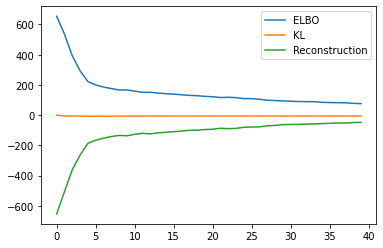

In [56]:
plt.plot(elbo_loss, label = 'ELBO')
plt.plot(kl_loss, label = 'KL')
plt.plot(rec_loss, label = 'Reconstruction')
plt.legend()

In [60]:
temp = next(iter(train_loader))
out, z, z_mean, z_logvar =  net(temp[0].float())
samples = net.structured_sampling(n_samples=40, dim = 0)

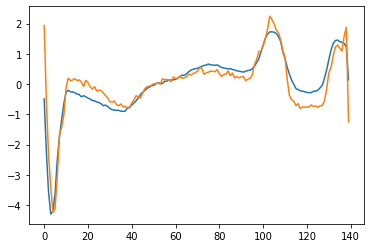

In [61]:
idx = 50
#x_hat = all_dec_mean[idx].detach().cpu()
#x_hat = net.sample(140).detach()
x_hat = out.detach().cpu()[idx,:,:]
plt.plot(x_hat)
plt.plot(temp[0][idx,:,:])

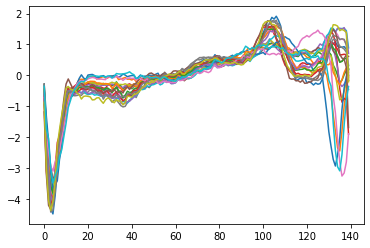

In [65]:
ids = np.arange(20,40)

for idx in ids:
    plt.plot(samples[idx,:,0])
plt.show()

In [204]:
z_logvar.mean(dim = 0)

tensor([0.0272, 0.1049, 0.1357, 0.0423, 0.4962, 0.6934, 0.0324, 0.5874, 0.3788,
        0.1146], grad_fn=<MeanBackward1>)

In [227]:
x_hat = x_hat.detach()
z = z.detach()
idx = 8
plt.plot(x_hat[idx,:,:])
plt.plot(temp[0][idx,:,:])

IndexError: too many indices for tensor of dimension 2

In [216]:
z_var.mean(dim = 0)

AttributeError: 'tuple' object has no attribute 'mean'